In [1]:
import librosa
import numpy as np
from scipy import stats
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import os

In [2]:

def extract_features_optimized(file_path, flag):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, duration=30) # Load up to 30 seconds
        
        # 1. MFCCs (Mean) - Captures Timbre
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)

        # 2. Delta MFCCs (Mean) - Captures Vocal Dynamics
        delta_mfccs = librosa.feature.delta(mfccs)
        delta_mfccs_mean = np.mean(delta_mfccs, axis=1)
        delta_mfccs_std = np.std(delta_mfccs, axis=1)

        # 3. Delta-Delta MFCCs (Mean) - Captures Acceleration of Dynamics
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        delta2_mfccs_mean = np.mean(delta2_mfccs, axis=1)
        delta2_mfccs_std = np.std(delta2_mfccs, axis=1)

        # 4. Chroma Features (Mean) - Captures Harmonic Profile
        chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chromagram, axis=1)

        # 5. F0 / Pitch (Standard Deviation) - Captures Vibrato & Pitch Stability
        f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        # Get statistics only on the voiced frames where F0 is reliable
        voiced_f0 = f0[voiced_flag]
        if len(voiced_f0) > 0:
            f0_std = np.std(voiced_f0)
        else:
            f0_std = 0 # If no voice is detected, vibrato/stability is 0
        f0_std_feature = np.array([f0_std]) # Make it a 1-element array

        # 6. Spectral Centroid (Mean) - Captures "Brightness"
        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_centroid_mean = np.mean(spec_centroid, axis=1)
        spec_centroid_std = np.std(spec_centroid, axis=1)

        # 7. Zero-Crossing Rate (Mean) - Captures Noisiness/Breathiness
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr, axis=1)
        zcr_std = np.std(zcr, axis=1)
        
        # 8. RMS Energy (Mean) - Captures Average Loudness
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms, axis=1)
        rms_std = np.std(rms, axis=1)

        # 9. Spectral Bandwidth (Mean) - Captures "Fullness"
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spec_bw_mean = np.mean(spec_bw, axis=1)
        spec_bw_std = np.std(spec_bw, axis=1)
        
        # Combine all features into a single vector
        combined_features = np.hstack([
            mfccs_mean,
            mfccs_std,
            delta_mfccs_mean,
            delta_mfccs_std,
            delta2_mfccs_mean,
            delta2_mfccs_std,
            chroma_mean,
            f0_std_feature,
            spec_centroid_mean,
            spec_centroid_std,
            zcr_mean,
            zcr_std,
            rms_mean,
            rms_std,
            spec_bw_mean,
            spec_bw_std
        ])
        
        # Ensure there are no NaN values
        combined_features = np.nan_to_num(combined_features)

        return combined_features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        # Return a zero vector of the expected size if an error occurs
        # Expected size: 20(mfcc)+20(d)+20(d2)+12(chroma)+1(f0)+1(sc)+1(zcr)+1(rms)+1(sb) = 77
        return np.zeros(77)

In [3]:
def load_data(data_dir, flag):
    singer_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    features = []
    labels = []
    for i, singer in enumerate(singer_names):
        folder_path = os.path.join(data_dir, singer)
        
        if os.path.isdir(folder_path):
            print(f"Loading {singer} samples...")
            
            for audio_file in os.listdir(folder_path):
                if audio_file.endswith('.wav'):
                    file_path = os.path.join(folder_path, audio_file)
                    voice_features = extract_features_optimized(file_path, flag)
                    if features is not None:
                        print(f"\nSuccessfully extracted features for {file_path}.")
                        print(f"Shape of the final feature vector: {voice_features.shape}")
                        print("First 10 features:", voice_features[:10])
                    else:
                        print(f"Feature extraction failed for {file_path}.")
                    features.append(voice_features)
                    labels.append(i)
    return np.array(features), np.array(labels), singer_names

In [4]:
data_dir1 = '/home/nirjhar/CODE/greeneggsandham/training'
data_dir2 = '/home/nirjhar/CODE/greeneggsandham/testing-5s'

In [5]:
# Load the voice data
print("Loading voice samples...")
print("TRAINING SAMPLES...")
X_train, y_train, singer_names_train = load_data(data_dir1, "train")
print("TESTING SAMPLES...")
X_test, y_test, singer_names_test = load_data(data_dir2, "test")


print(f"Total samples: {len(X_train) + len(X_test)}")
print(f"Features per sample: {X_train.shape[1]}")


print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Loading voice samples...
TRAINING SAMPLES...
Loading arijit samples...

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_3.wav.
Shape of the final feature vector: (141,)
First 10 features: [-82.32489014 118.40859985   9.88502121   8.14506435   2.26774597
  -8.15877247 -20.1533432    6.41972113 -14.92082977  -2.00802279]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_4.wav.
Shape of the final feature vector: (141,)
First 10 features: [-80.66771698 136.17723083   6.0774107    5.52481699   8.95819664
  -9.90686512 -16.61009789  12.89629459  -5.38894463   4.90006971]

Successfully extracted features for /home/nirjhar/CODE/greeneggsandham/training/arijit/arijit_5.wav.
Shape of the final feature vector: (141,)
First 10 features: [-83.06949615 143.12945557  13.80796051  -3.40865803   7.03817415
  -7.6788168  -17.75269508   8.73736286 -13.72964382   7.90775871]

Successfully extracted features for /hom

In [6]:
scaler = RobustScaler()
# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(453, 141)
(61, 141)


In [ ]:
# # Feature selection with RFE
# estimator = SVC(kernel="linear")
# selector = RFE(estimator, n_features_to_select=10, step=1)
# selector = selector.fit(X_train_scaled, y_train)
# X_train_selected = selector.transform(X_train_scaled)
# X_test_selected = selector.transform(X_test_scaled)

In [18]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'decision_function_shape': ['ovr', 'ovo'],
    'gamma': [0.1, 1, 'auto', 'scale']
}

In [21]:
# Create and train SVM classifier
model = SVC()
grid_search = GridSearchCV(
  estimator=model,
  param_grid=param_grid,
  cv=5,
  scoring='accuracy',
  n_jobs=-1,
)
grid_search.fit(X_train_scaled, y_train)

,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'decision_function_shape': ['ovr', 'ovo'], 'gamma': [0.1, 1, ...], 'kernel': ['rbf', 'linear']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [ ]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")
# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f} ({accuracy * 100:.2f}%)")


Best parameters: {'C': 10, 'decision_function_shape': 'ovr', 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.946959706959707
Test set accuracy: 0.82 (81.97%)


Exception ignored in: <function ResourceTracker.__del__ at 0x7fc13ca9a7a0>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f426ff967a0>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f5ecb49a7a0>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/reso

In [11]:
# Test the model
# y_pred = model.predict(X_test)
# print("Testing the SVM model...")
# Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)

# print(f"Accuracy: {accuracy:.2f} ({accuracy*100:.1f}%)")

In [12]:
# Show some predictions
print("\nSample predictions:")
for i in range(min(5, len(X_test))):
    actual = singer_names_test[y_test[i]]
    predicted = singer_names_test[y_pred[i]]
    print(f"Actual: {actual}, Predicted: {predicted}")


Sample predictions:
Actual: arijit, Predicted: arijit
Actual: arijit, Predicted: arijit
Actual: arijit, Predicted: arijit
Actual: arijit, Predicted: arijit
Actual: arijit, Predicted: arijit


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd

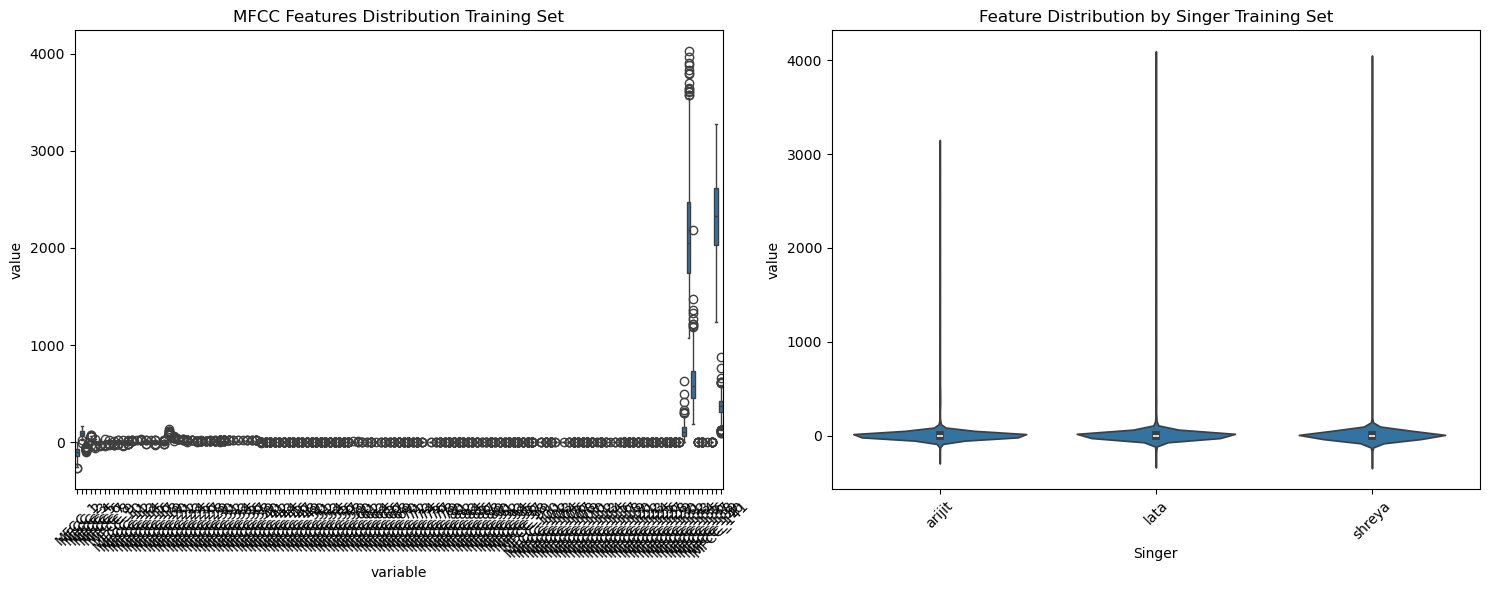

In [14]:
# Visualize MFCC feature distributions
plt.figure(figsize=(15, 6))
features_df = pd.DataFrame(X_train, columns=[f'MFCC_{i+1}' for i in range(X_train.shape[1])])
features_df['Singer'] = [singer_names_train[i] for i in y_train]

plt.subplot(1, 2, 1)
sns.boxplot(data=features_df.melt(id_vars=['Singer']), x='variable', y='value')
plt.xticks(rotation=45)
plt.title('MFCC Features Distribution Training Set')

plt.subplot(1, 2, 2)
sns.violinplot(data=features_df.melt(id_vars=['Singer']), x='Singer', y='value')
plt.xticks(rotation=45)
plt.title('Feature Distribution by Singer Training Set')
plt.tight_layout()
plt.show()

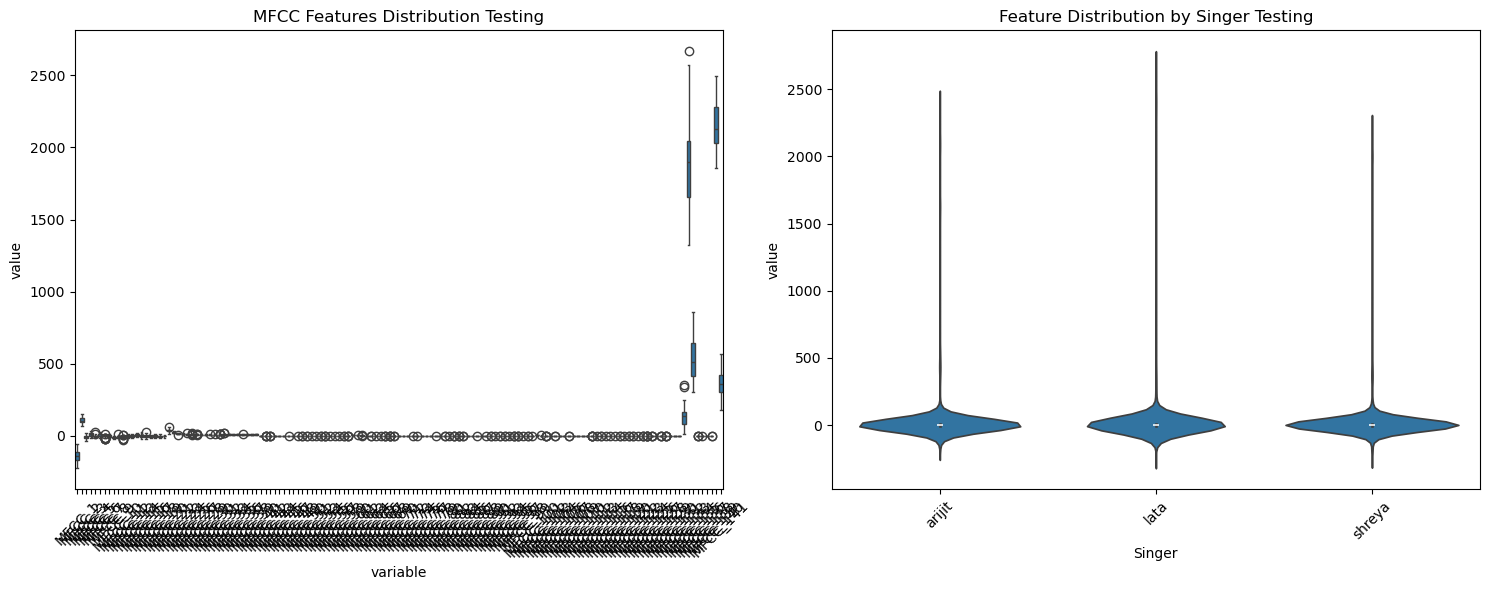

In [15]:
# Visualize MFCC feature distributions
plt.figure(figsize=(15, 6))
features_df = pd.DataFrame(X_test, columns=[f'MFCC_{i+1}' for i in range(X_test.shape[1])])
features_df['Singer'] = [singer_names_test[i] for i in y_test]

plt.subplot(1, 2, 1)
sns.boxplot(data=features_df.melt(id_vars=['Singer']), x='variable', y='value')
plt.xticks(rotation=45)
plt.title('MFCC Features Distribution Testing')

plt.subplot(1, 2, 2)
sns.violinplot(data=features_df.melt(id_vars=['Singer']), x='Singer', y='value')
plt.xticks(rotation=45)
plt.title('Feature Distribution by Singer Testing')
plt.tight_layout()
plt.show()

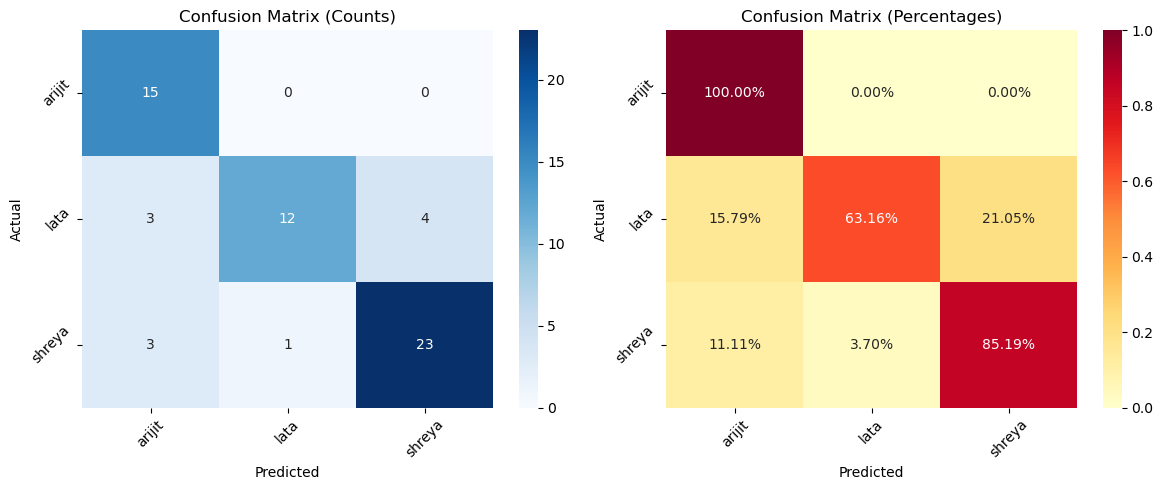

In [16]:
# Enhanced confusion matrix visualization
def plot_confusion_matrix():
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 5))
    
    # Absolute numbers
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=singer_names_test,
                yticklabels=singer_names_test)
    plt.title('Confusion Matrix (Counts)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    # Percentages
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=singer_names_test,
                yticklabels=singer_names_test)
    plt.title('Confusion Matrix (Percentages)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrix()